In [1]:
import cv2
import numpy as np
from math import *
from skimage import io
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

%matplotlib inline

def cv2_imshow(img):
    return plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

def url_to_image(url):
    print("downloading %s" % (url))
    return cv2.cvtColor(io.imread(url), cv2.COLOR_BGR2RGB)

In [2]:
figsize(12,16)

downloading https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/tasks/ellipses/e1.jpg


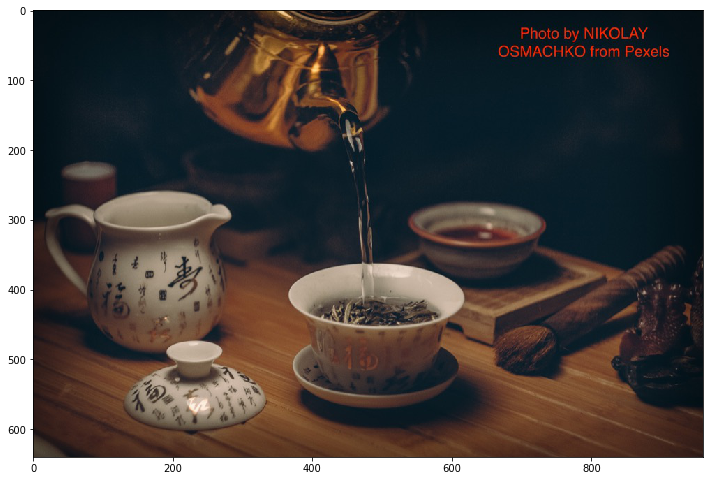

In [3]:
url2 = "https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/tasks/ellipses/e1.jpg"
imgc = url_to_image(url2)
cv2_imshow(imgc)

In [4]:
def find_elips_5(img, points):
    img = imgc.copy()

    m = np.zeros((5,5), dtype=np.double)
    r = np.zeros((5,1), dtype=np.double)

    for k in range(0, len(points)):
        m[k][0] = 2*points[k][0]*points[k][1]
        m[k][1] = points[k][1]*points[k][1]
        m[k][2] = 2*points[k][0]
        m[k][3] = 2*points[k][1]
        m[k][4] = 1
        r[k] = points[k][0]*points[k][0]

    p = -np.matmul(np.linalg.inv(m), r)

    # p[0]=H  p[1]=B  p[2]=G  p[3]=F  p[4]=C
    E = np.array(
          [[  1, p[0], p[2]],
          [p[0], p[1], p[3]],
          [p[2], p[3], p[4]] ], np.double )

    print(E)

    print( "Ellipse " if E[0,0]*E[1,1]>E[0,1]*E[1,0] else "Not Ellipse!!!")

    # result on given points:
    for k in range(0, len(points)):
      print( np.matmul( np.matmul( [ [points[k][0], points[k][1], 1] ], E ), [[points[k][0]],[points[k][1]],[1]] ) )

    #find circle->ellipse conversion
    u, s, v = np.linalg.svd(E)
    u2 = np.matmul(u, np.diag(np.sqrt(s)) )
    H = np.linalg.inv( u2.T)

    print( "u = ", u )
    print( "m1v.T = ", np.matmul(np.diag([1,1,-1]),  v ).T)

    print( "v = ", v )
    print( "usv = ", np.matmul(np.matmul(u, np.diag(s)), v) )



    # draw ellipse
    for alpha in range(0,360):
      a1 = np.matmul( H, [[sin(pi*alpha/180)], [cos(pi*alpha/180)], [1]] )
      a1 = (a1/a1[2])
      a2 = np.matmul( H, [[sin(pi*(alpha+1)/180)], [cos(pi*(alpha+1)/180)], [1]] )
      a2 = (a2/a2[2])
      cv2.line(img, (a1[0],a1[1]),(a2[0],a2[1]),(0,0,255), 1)

    for k in range(0, len(points)):
      cv2.circle(img, (int(points[k][0]),int(points[k][1])),3,(0,255,0))

    return cv2_imshow(img)

[[ 1.00000000e+00 -1.43150926e-01 -4.33622798e+02]
 [-1.43150926e-01  7.15055419e+00 -2.85454121e+03]
 [-4.33622798e+02 -2.85454121e+03  1.36521838e+06]]
Ellipse 
[[-2.18569767e-08]]
[[-2.45345291e-08]]
[[-2.19079084e-08]]
[[-2.42143869e-08]]
[[-2.49710865e-08]]
u =  [[-3.17619447e-04  6.51716385e-01  7.58462690e-01]
 [-2.09090136e-03 -7.58461504e-01  6.51714489e-01]
 [ 9.99997764e-01 -1.37887347e-03  1.60357680e-03]]
m1v.T =  [[-3.17619447e-04  6.51716385e-01  7.58462690e-01]
 [-2.09090136e-03 -7.58461504e-01  6.51714489e-01]
 [ 9.99997764e-01 -1.37887347e-03  1.60357680e-03]]
v =  [[-3.17619447e-04 -2.09090136e-03  9.99997764e-01]
 [ 6.51716385e-01 -7.58461504e-01 -1.37887347e-03]
 [-7.58462690e-01 -6.51714489e-01 -1.60357680e-03]]
usv =  [[ 1.00000000e+00 -1.43150926e-01 -4.33622798e+02]
 [-1.43150926e-01  7.15055419e+00 -2.85454121e+03]
 [-4.33622798e+02 -2.85454121e+03  1.36521838e+06]]


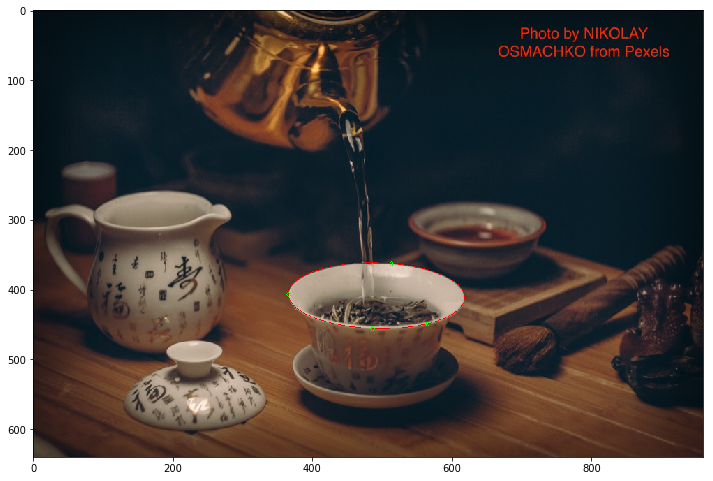

In [6]:
points = np.array([ [366, 407], [513, 363], [377, 426], [486, 456], [565, 449]] , np.double)
find_elips_5(imgc, points)

# To find ellipse with 6+ known points I utilized approach to solution of overdetermined system: solving the normal equation we can get the best approximate solution in the following form:
$$p=(M^TM)^{-1}Mr$$

In [7]:
def find_elips_n(img, points, debug=True):
    img = imgc.copy()
    n = len(points)
    m = np.zeros((n,5), dtype=np.double)
    r = np.zeros((n,1), dtype=np.double)

    for k in range(0, len(points)):
        m[k][0] = 2*points[k][0]*points[k][1]
        m[k][1] = points[k][1]*points[k][1]
        m[k][2] = 2*points[k][0]
        m[k][3] = 2*points[k][1]
        m[k][4] = 1
        r[k] = points[k][0]*points[k][0]

    m_t = np.transpose(m)
    p = -np.matmul(np.matmul(np.linalg.inv(np.matmul(m_t, m)), m_t), r)

    # p[0]=H  p[1]=B  p[2]=G  p[3]=F  p[4]=C
    E = np.array(
          [[  1, p[0], p[2]],
          [p[0], p[1], p[3]],
          [p[2], p[3], p[4]] ], np.double )

    if debug:
        print(E)
        print( "Ellipse " if E[0,0]*E[1,1]>E[0,1]*E[1,0] else "Not Ellipse!!!")

        # result on given points:
        for k in range(0, len(points)):
            print( np.matmul( np.matmul( [ [points[k][0], points[k][1], 1] ], E ), [[points[k][0]],[points[k][1]],[1]] ) )

    #find circle->ellipse conversion
    u, s, v = np.linalg.svd(E)
    u2 = np.matmul(u, np.diag(np.sqrt(s)) )
    H = np.linalg.inv( u2.T)

    if debug:
        print( "u = ", u )
        print( "m1v.T = ", np.matmul(np.diag([1,1,-1]),  v ).T)
        print( "v = ", v )
        print( "usv = ", np.matmul(np.matmul(u, np.diag(s)), v) )

    # draw ellipse
    for alpha in range(0,360):
        a1 = np.matmul( H, [[sin(pi*alpha/180)], [cos(pi*alpha/180)], [1]] )
        a1 = (a1/a1[2])
        a2 = np.matmul( H, [[sin(pi*(alpha+1)/180)], [cos(pi*(alpha+1)/180)], [1]] )
        a2 = (a2/a2[2])
        cv2.line(img, (a1[0],a1[1]),(a2[0],a2[1]),(0,0,255), 1)

    for k in range(0, len(points)):
        cv2.circle(img, (int(points[k][0]),int(points[k][1])),3,(0,255,0),3)

    return p, cv2_imshow(img)

[[ 1.00000000e+00 -1.44167413e-01 -4.33169662e+02]
 [-1.44167413e-01  7.14687592e+00 -2.85255036e+03]
 [-4.33169662e+02 -2.85255036e+03  1.36417653e+06]]
Ellipse 
[[-1.73827128]]
[[5.16639995]]
[[-5.00329541]]
[[2.00318429]]
[[-1.12905509]]
[[0.70102409]]
u =  [[-3.17529851e-04  6.51739272e-01  7.58443023e-01]
 [-2.09103884e-03 -7.58441836e-01  6.51737377e-01]
 [ 9.99997763e-01 -1.37898775e-03  1.60364006e-03]]
m1v.T =  [[-3.17529851e-04  6.51739272e-01  7.58443023e-01]
 [-2.09103884e-03 -7.58441836e-01  6.51737377e-01]
 [ 9.99997763e-01 -1.37898775e-03  1.60364006e-03]]
v =  [[-3.17529851e-04 -2.09103884e-03  9.99997763e-01]
 [ 6.51739272e-01 -7.58441836e-01 -1.37898775e-03]
 [-7.58443023e-01 -6.51737377e-01 -1.60364006e-03]]
usv =  [[ 1.00000000e+00 -1.44167413e-01 -4.33169662e+02]
 [-1.44167413e-01  7.14687592e+00 -2.85255036e+03]
 [-4.33169662e+02 -2.85255036e+03  1.36417653e+06]]


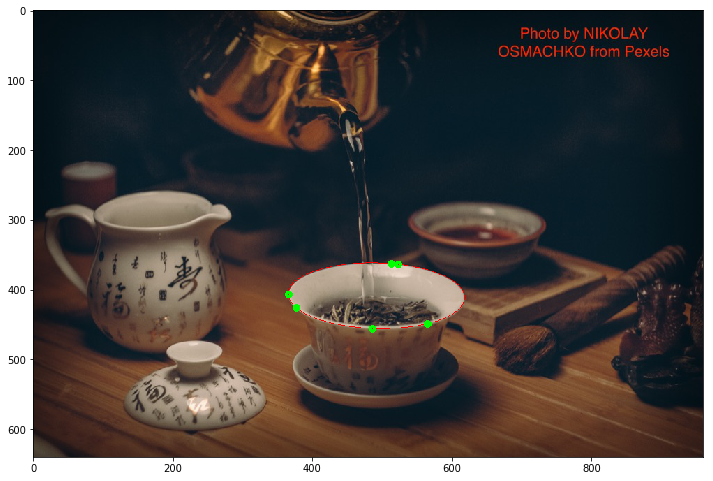

In [8]:
points = np.array([ [366, 407], [513, 363], [523, 364], [377, 426], [486, 456], [565, 449]] , np.double)
p, _ = find_elips_n(imgc, points)

# Let's consider previous result as a true ellipse for these 6 points. Let's consider distance between allipses as L2-distance between their parameters vectors.

# Let's investigate how distance between found ellipses depends on noise in the point measurments:

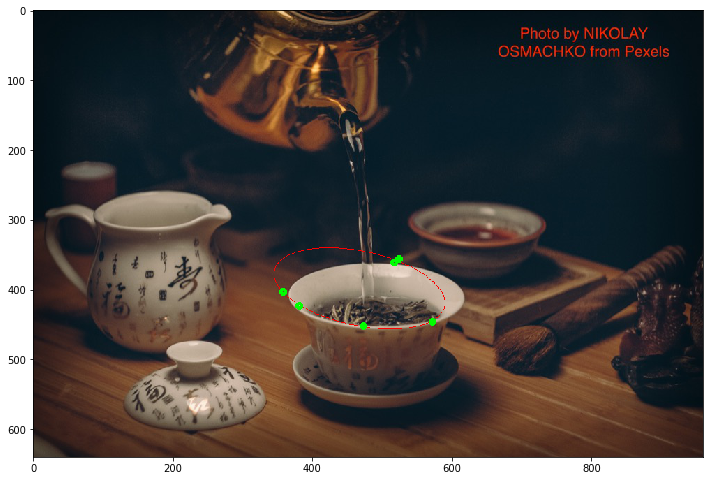

In [9]:
reference = p
dist = []

np.random.seed(17)
errors = np.random.normal(loc=0, scale=5, size=(1000,6,2))

for err in errors:
    par, _ = find_elips_n(imgc, points + err, debug=False)
    dist.append(np.linalg.norm(reference-par))

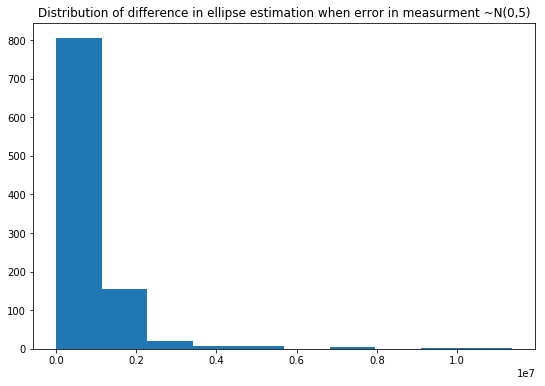

In [10]:
figsize(9,6)
plt.title("Distribution of difference in ellipse estimation when error in measurment ~N(0,5)")
plt.hist(dist);

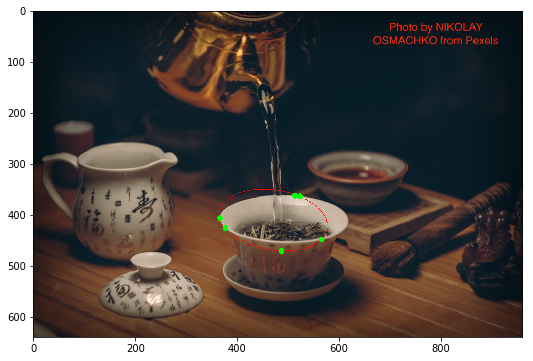

In [11]:
reference = p
distances = []

np.random.seed(17)
errors = np.linspace(-15,15,100)

for i in range(5):
    dist =[]
    for err in errors:
        x = np.random.randint(0, 2)
        y = np.random.randint(0, 6)
        new_points = points.copy()
        new_points[y][x] += err
        par, _ = find_elips_n(imgc, new_points, debug=False)
        dist.append(np.linalg.norm(reference-par))
    distances.append(dist)

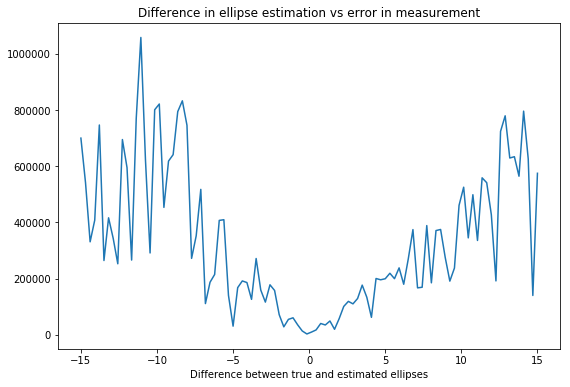

In [12]:
plt.title("Difference in ellipse estimation vs error in measurement")
plt.xlabel("Error in measurement")
plt.xlabel("Difference between true and estimated ellipses")
plt.plot(errors, np.mean(distances, axis=0));

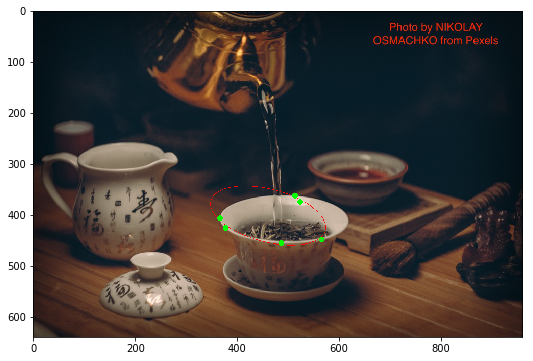

In [13]:
reference = p
distances = []

np.random.seed(17)
errors = np.random.normal(0,5,100)

for i in range(5):
    dist =[]
    for err in errors:
        x = np.random.randint(0, 2)
        y = np.random.randint(0, 6)
        new_points = points.copy()
        new_points[y][x] += err
        par, _ = find_elips_n(imgc, new_points, debug=False)
        dist.append(np.linalg.norm(reference-par))
    distances.append(dist)


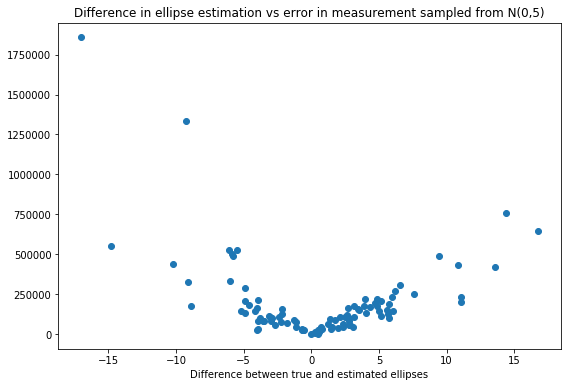

In [14]:
plt.title("Difference in ellipse estimation vs error in measurement sampled from N(0,5)")
plt.xlabel("Error in measurement")
plt.xlabel("Difference between true and estimated ellipses")
plt.plot(errors, np.mean(distances, axis=0), 'o');

# We observe, that with OLS approach for ellipse estimation difference between true and estimated ellipses growth faster than linearly. So this method should be utilized only if measurements are precise enough.
# In other words, OLS estimation of elipse from 6 measurements (points) is very sensitive to big errors/noise in measurement, while tollerates small one pretty well.